In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch

/home/vin/.pyenv/versions/3.10.6/envs/sentiscope/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import transformers
print(transformers.__version__)

4.41.2


In [5]:

# Load your cleaned CSV
df = pd.read_csv('../raw_data/train_df_ml_clean.csv')  # adjust path if needed

# Sample a small number of rows (e.g., 2000)
df_sample = df.sample(n=2000, random_state=42).reset_index(drop=True)

df_sample.head()

,label,text,clean_text
0,0,Expensive Junk: This product consists of a pie...,expensive junk this product consists of a piec...
1,0,"Toast too dark: Even on the lowest setting, th...",toast too dark even on the lowest setting the ...
2,1,Excellent imagery...dumbed down story: I enjoy...,excellent imagerydumbed down story i enjoyed t...
3,0,Are we pretending everyone is married?: The au...,are we pretending everyone is married the auth...
4,0,Not worth your time: Might as well just use a ...,not worth your time might a well just use a kn...


In [6]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [7]:
dataset = Dataset.from_pandas(df_sample[['clean_text', 'label']])


In [8]:
dataset = dataset.rename_column("clean_text", "text")

In [9]:
# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

In [10]:

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 2000/2000 [00:03<00:00, 539.38 examples/s]


In [11]:
tokenized_dataset = tokenized_dataset.remove_columns(["text"])  # Remove original text
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

tokenized_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2000
})

In [12]:
# Use Hugging Face's built-in train_test_split
train_test = tokenized_dataset.train_test_split(test_size=0.2)

train_dataset = train_test['train']
eval_dataset = train_test['test']

len(train_dataset), len(eval_dataset)

(1600, 400)

In [13]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="no"
)

/home/vin/.pyenv/versions/3.10.6/envs/sentiscope/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.366200,0.384888
2,0.186600,0.428005


TrainOutput(global_step=400, training_loss=0.2981948637962341, metrics={'train_runtime': 2450.5174, 'train_samples_per_second': 1.306, 'train_steps_per_second': 0.163, 'total_flos': 263526277494240.0, 'train_loss': 0.2981948637962341, 'epoch': 2.0})

In [18]:
predictions = trainer.predict(eval_dataset)

In [19]:
pred_labels = np.argmax(predictions.predictions, axis=1)
print(pred_labels[:20])

[0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0]


In [21]:
from sklearn.metrics import classification_report
# Ground truth labels
true_labels = eval_dataset['labels']

# Predicted labels
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       209
           1       0.87      0.92      0.89       191

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



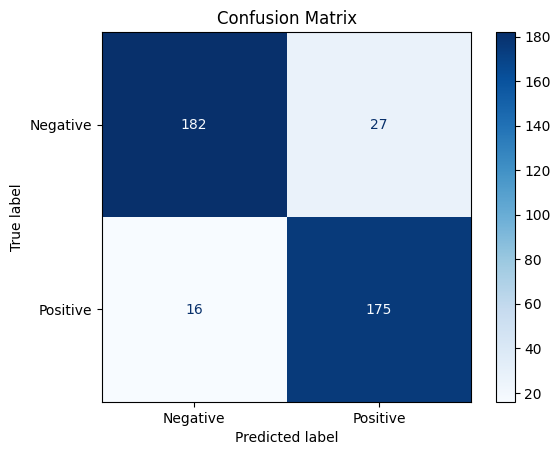

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [23]:
model.save_pretrained("./sentiment-bert")
tokenizer.save_pretrained("./sentiment-bert")

('./sentiment-bert/tokenizer_config.json',
 './sentiment-bert/special_tokens_map.json',
 './sentiment-bert/vocab.txt',
 './sentiment-bert/added_tokens.json')